# Experimenting with Superresolution

*Author: Aaron Berk*

## Set-up

dnCNN or U-Net takes an image from e.g. 128 x 128 to 256 x 256. 

In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('..')
from util import show, plot_images, plot_tensors

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.measure import compare_psnr

In [3]:
import pywt

from models.babyunet import BabyUnet

import hiddenlayer

import torch

In [5]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset

mnist_train = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = True)

mnist_test = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = False)

In [6]:
from torch import randn
def add_noise(img):
    return img + randn(img.size())*0.4

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img

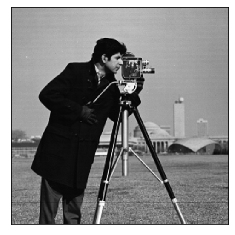

In [7]:
image = img_as_float(data.camera())
show(image)

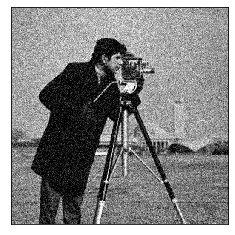

In [8]:
np.random.seed(3)
noisy_image = random_noise(image, mode = 'gaussian', var=0.01)
show(noisy_image)

In [9]:
noisy = torch.Tensor(noisy_image[np.newaxis, np.newaxis])

In [10]:
noisy_wtcoeff = pywt.wavedec2(noisy_image, 'db1')

In [11]:
len(noisy_wtcoeff)

10

In [12]:
noisy_downsampled_image = pywt.waverec2(noisy_wtcoeff[:-1], 'db1')

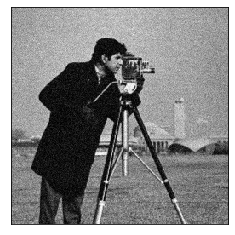

In [13]:
show(noisy_downsampled_image)

In [4]:
bun = BabyUnet(width=8)

../models/modules.py:87: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  x[:, 0 : min(ox.shape[1], x.shape[1]), :, :] += ox[
../models/modules.py:87: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  x[:, 0 : min(ox.shape[1], x.shape[1]), :, :] += ox[
../models/modules.py:88: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  :, 0 : min(ox.shape[1]

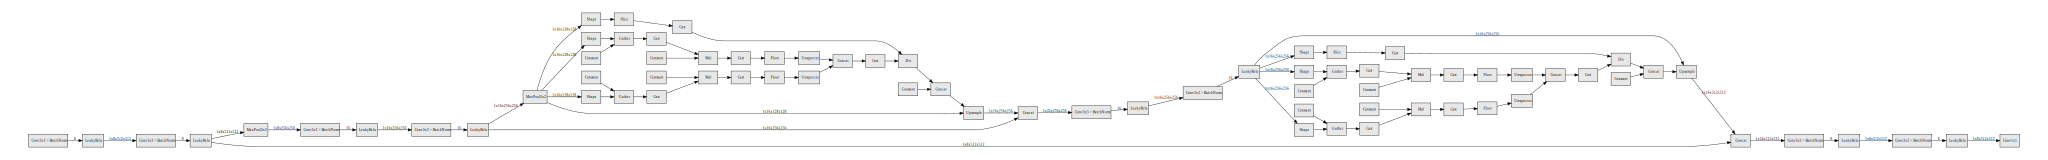

In [5]:
hiddenlayer.build_graph(bun, torch.zeros(1, 1, 512, 512))

In [6]:
torch.__version__

'1.3.0'

In [7]:
from models.modules import ConvBlock

In [8]:
x = torch.randn(1, 1, 512, 512)

In [9]:
cb = ConvBlock(1, 6)

In [10]:
x

tensor([[[[-0.5080, -0.6190,  0.0822,  ...,  1.0525,  0.2727, -2.6283],
          [-0.4103,  1.3828, -0.6447,  ...,  0.0666,  0.7561,  1.2958],
          [ 0.1310, -1.5144,  1.3951,  ...,  0.4914, -0.1920,  1.8671],
          ...,
          [ 0.0317,  1.1867, -0.8645,  ..., -0.3891,  1.0852, -0.9348],
          [-0.0822, -0.6779,  1.6905,  ...,  0.5924,  0.4459,  1.9896],
          [-0.4441, -1.8900, -0.6515,  ...,  0.3347, -0.0822,  2.0475]]]])

In [11]:
cb(x)
x

tensor([[[[-0.5080, -0.6190,  0.0822,  ...,  1.0525,  0.2727, -2.6283],
          [-0.4103,  1.3828, -0.6447,  ...,  0.0666,  0.7561,  1.2958],
          [ 0.1310, -1.5144,  1.3951,  ...,  0.4914, -0.1920,  1.8671],
          ...,
          [ 0.0317,  1.1867, -0.8645,  ..., -0.3891,  1.0852, -0.9348],
          [-0.0822, -0.6779,  1.6905,  ...,  0.5924,  0.4459,  1.9896],
          [-0.4441, -1.8900, -0.6515,  ...,  0.3347, -0.0822,  2.0475]]]])

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from models.modules import ConvBlock


class BabyUnet(nn.Module):
    def __init__(self, n_channel_in=1, n_channel_out=1, width=16):
        super(BabyUnet, self).__init__()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.up1 = lambda x: F.interpolate(
            x, mode="bilinear", scale_factor=2, align_corners=False
        )
        self.up2 = lambda x: F.interpolate(
            x, mode="bilinear", scale_factor=2, align_corners=False
        )

        self.conv1 = ConvBlock(n_channel_in, width)
        self.conv2 = ConvBlock(width, 2 * width)

        self.conv3 = ConvBlock(2 * width, 2 * width)

        self.conv4 = ConvBlock(4 * width, 2 * width)
        self.conv5 = ConvBlock(3 * width, width)

        self.conv6 = nn.Conv2d(width, n_channel_out, 1)

    def forward(self, x):
        c1 = self.conv1(x)
        x = self.pool1(c1)
        c2 = self.conv2(x)
        x = self.pool2(c2)
        x = self.conv3(x)

        x = self.up1(x)
        x = torch.cat([x, c2], 1)
        x = self.conv4(x)
        x = self.up2(x)
        x = torch.cat([x, c1], 1)
        x = self.conv5(x)
        x = self.conv6(x)
        return x


In [13]:
bun2 = BabyUnet(width=8)

In [18]:
aa = torch.randn(1,1,512,512)

In [25]:
aa.shape

torch.Size([1, 1, 512, 512])

In [28]:
aa.flatten().reshape(aa.shape)

tensor([[[[ 0.6566, -1.2438,  1.9117,  ...,  0.7457, -0.1015,  1.2112],
          [ 0.1199, -0.3181, -0.4256,  ...,  0.8900, -0.0584, -0.9929],
          [-0.9081, -0.4705,  2.1838,  ..., -1.4982, -0.3124, -0.6622],
          ...,
          [-0.9924,  0.9755,  0.5220,  ...,  0.6358,  0.7837,  0.7042],
          [ 0.5302,  1.6326,  1.3199,  ...,  1.2749, -0.4949,  0.0122],
          [ 0.3522,  0.9974,  1.0441,  ..., -0.9329,  0.3301, -0.5734]]]])

In [16]:
bun2(torch.randn(1, 1, 512, 512)).shape

torch.Size([1, 1, 512, 512])

In [17]:
bun2(torch.randn(1, 1, 256, 256)).shape

torch.Size([1, 1, 256, 256])